In [23]:
#%% -------- 0. Configuration & Paths --------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from skimage.filters import frangi
from skimage.morphology import erosion, dilation, disk
from skimage.filters.rank import entropy
from PIL import Image
import os
from tqdm import tqdm

DATA_ROOT = Path("D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs")
SPLITS = {
    'train': DATA_ROOT / "train",
    'val': DATA_ROOT / "val",
    'test': DATA_ROOT / "test"
}
class_names = ['Male', 'Female']

In [24]:
#%% -------- 1. Custom Preprocessing Pipeline --------
class DentalPreprocessor:
    def __init__(self, clip_limit=2.0, grid_size=(8,8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
        
    def __call__(self, img):
        img_np = np.array(img)
        clahe_img = self.clahe.apply(img_np)
        frangi_img = frangi(clahe_img, sigmas=range(1, 3, 1))
        entropy_img = entropy(clahe_img, disk(7))
        return torch.from_numpy(self.dynamic_morphology(frangi_img, entropy_img)).float().unsqueeze(0)
    
    def dynamic_morphology(self, img, entropy_img, threshold=0.5):
        selem = disk(2)
        normalized_entropy = (entropy_img - entropy_img.min()) / (entropy_img.max() - entropy_img.min())
        mask = normalized_entropy > threshold
        processed = np.zeros_like(img)
        processed[mask] = dilation(img[mask], selem)
        processed[~mask] = erosion(img[~mask], selem)
        return processed

In [25]:
#%% -------- 2. Custom Dataset Class --------
class DentalDataset(Dataset):
    def __init__(self, transform=None, mode='train'):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        split_dir = SPLITS[mode]
        for class_idx, class_name in enumerate(class_names):
            class_dir = split_dir / class_name.lower()
            images = list(class_dir.glob("*.[pj][np]g"))  # Match png/jpg
            self.image_paths.extend(images)
            self.labels.extend([class_idx] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [26]:
#%% -------- 3. Data Preparation --------
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    DentalPreprocessor(),
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    DentalPreprocessor(),
])

train_dataset = DentalDataset(transform=train_transform, mode='train')
val_dataset = DentalDataset(transform=val_transform, mode='val')
test_dataset = DentalDataset(transform=val_transform, mode='test')

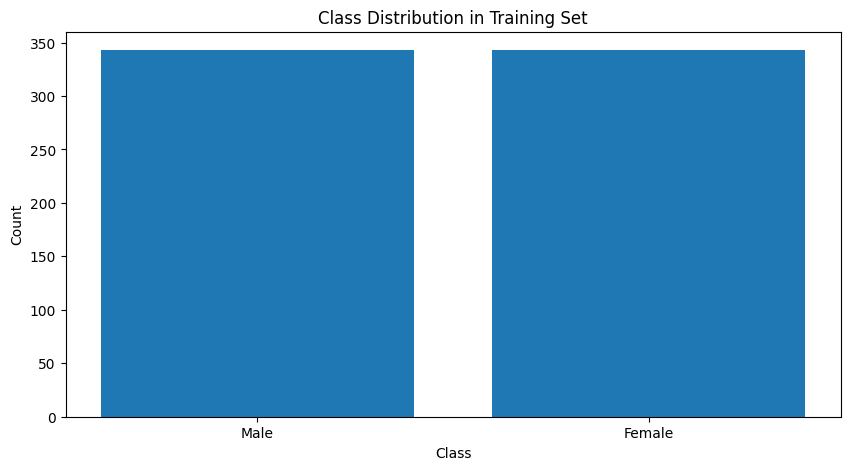

RuntimeError: footprint array has incorrect shape.

<Figure size 1500x1000 with 0 Axes>

In [27]:
#%% -------- 4. Data Visualization --------
def plot_class_distribution():
    counts = np.bincount(train_dataset.labels)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 3, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)

In [28]:
#%% -------- 5. Model Architecture --------
class DentalGenderClassifier(nn.Module):
    def __init__(self, patch_size=7, embed_dim=256, num_heads=8, num_layers=6):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((14, 14)))
        
        self.patch_embed = nn.Linear(128*patch_size**2, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.classifier = nn.Linear(embed_dim, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, x):
        features = self.cnn(x)
        b, c, h, w = features.shape
        
        # Patch extraction
        patches = features.unfold(2, 7, 7).unfold(3, 7, 7)
        patches = patches.contiguous().view(b, -1, 128*7*7)
        
        embeddings = self.patch_embed(patches)
        encoded = self.transformer(embeddings)
        pooled = encoded.mean(dim=1)
        return torch.sigmoid(self.classifier(pooled))

In [29]:
#%% -------- 6. Training Setup --------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DentalGenderClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
criterion = nn.BCELoss()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=4)

In [30]:
#%% -------- 7. Training Loop --------
best_accuracy = 0
for epoch in range(50):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        images, labels = images.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Val Acc: {accuracy:.2f}%")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1:   0%|          | 0/43 [00:00<?, ?it/s]


TypeError: cannot pickle 'cv2.CLAHE' object

In [ ]:
#%% -------- 8. Evaluation --------
model.load_state_dict(torch.load('best_model.pth'))
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

In [ ]:
#%% -------- 9. Visualization --------
def predict_and_visualize(model, dataset, num_images=9):
    model.eval()
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            prob = model(img_tensor).item()
            pred_label = int(prob > 0.5)
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {prob:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(model, test_dataset)
print("Pipeline executed successfully!")